# A pyspeckit example for GBspec

This version uses pyspeckit, but you will need the "teuben-gbt" branch, where the hacking is going on to deal with missing variables in this old data. There are also a few other bugs/software rot that were fixed, perhaps because I've changed to python3.

This should reproduce Example 1 from the GBTIDL manual. The datafile you need is [here](http://safe.nrao.edu/wiki/pub/GB/Data/GBTIDLExampleAndSampleData/ngc5291.fits).

## SDFITS

We begin by disecting the typical SDFITS file, starting with raw plotting



In [1]:
# %matplotlib inline
%matplotlib

from astropy.io import fits
from astropy import units as u
import numpy as np
from matplotlib import pyplot as plt

from pyspeckit.spectrum.readers import gbt



Using matplotlib backend: Qt5Agg


A useful stats routine so we can regress if we see the same data

In [2]:
def my_stats(label,data):
    """
    for regression
    """
    mean = data.mean()
    rms  = data.std()
    dmin = data.min()
    dmax = data.max()
    ndat = len(data)
    print("%s  %s %s %s %s %d" %  (label,repr(mean),repr(rms),repr(dmin),repr(dmax),ndat))

In [3]:
def uniq(seq):
    """ from http://stackoverflow.com/questions/480214/how-do-you-remove-duplicates-from-a-list-in-python-whilst-preserving-order """
    seen = set()
    seen_add = seen.add
    return [ x for x in seq if x not in seen and not seen_add(x)]


In [4]:
sdfits = { 'file' : 'ngc5291.fits',                     'src' : 'NGC5291'  }
#sdfits = { 'file' : '3C286.fits',                       'src' : '3C286'    }
#sdfits = { 'file' : 'IC1481.fits',                      'src' : 'IC1481'   }
#sdfits = { 'file' : 'AGBT15B_287_35.raw.vegas.A.fits',  'src' : 'NGC2347'  }
#sdfits = { 'file' : 'AGBT17B_151_01.raw.vegas.A.fits',  'src' : 'IC0342'   }

Start a session from a single SDFITS name. For future work we will need to be able to handle a directory (cf. the **dirin** command in GBTIDL) where several related SDFITS are located.  E.g. ARGUS uses 8.  The EDGE project has 3.

Loading a session is fast. It gives a quick overview, but it doesn't really load any data.

In [5]:
%%time 
fname = sdfits['file']
src   = sdfits['src']
session = gbt.GBTSession(fname)
print(session)

SINGLE DISH  NGC5291  131458 x 352
Observer: Jeff Mangum
Project: AGBT05B_047_01
Backend: Spectrometer
Telescope: NRAO_GBT
Bandwidth: 50000000.0
Date: 2005-06-27T02:05:58.00

       Object Name          RA        DEC           RA           DEC N(ptgs)  Exp.Time requested   n(ints)
           NGC5291  206.851994 -30.257141                                 88    859.48    859.48       176
CPU times: user 42.8 ms, sys: 0 ns, total: 42.8 ms
Wall time: 42.1 ms


In [6]:
%%time 
srcs = list(session.targets.keys())
print("Found %s" % srcs)
print("Using %s" % src)

Found ['NGC5291']
Using NGC5291
CPU times: user 135 µs, sys: 14 µs, total: 149 µs
Wall time: 155 µs


Load all blocks, as defined by a uniq (sampler,nod,....) tuplet

For GBT sampler is typically polarization (XX and YY) and multi-beam pointing (for ARGUS there are 16)

Loading all blocks, at least the way it's done in pyspeckit, can be VERY VERY slow. clearly needs a different approach.


In [7]:
%%time
print("")
print("NOTE: This command can take a while: load_target(%s)" % src)
print("")
session.load_target(src, verbose=True)
print(fname)


NOTE: This command can take a while: load_target(NGC5291)

Number of individual scans for Object NGC5291: 352
Number of spectra for sampler A13, nod 1, calON: 44
Number of spectra for sampler A13, nod 1, calOFF: 44
Number of spectra for sampler A13, nod 2, calON: 44
Number of spectra for sampler A13, nod 2, calOFF: 44
Number of spectra for sampler A9, nod 1, calON: 44
Number of spectra for sampler A9, nod 1, calOFF: 44
Number of spectra for sampler A9, nod 2, calON: 44
Number of spectra for sampler A9, nod 2, calOFF: 44
ngc5291.fits
CPU times: user 17.4 s, sys: 368 ms, total: 17.7 s
Wall time: 12.8 s


The dimensionality of 
    * NGC5291:    DATA(cal[2], int[11], sampler[2], proc[2], scan[4])
    * IC1481:     DATA(cal[2], int[4], pol[2], sampler[4], proc[2], scan[4])
    * NGC2347:    DATA(cal[2], pol[2], int[41]; scan[9 or 3], if[3])
    
    

In [8]:
%%time 
target = session[src]
print(target)
blocks = list(target.blocks.keys())
print('Found blocks',blocks)


Object NGC5291 with 8 scan blocks and 0 'reduced' spectra
Found blocks ['A13ON1', 'A13OFF1', 'A13ON2', 'A13OFF2', 'A9ON1', 'A9OFF1', 'A9ON2', 'A9OFF2']
CPU times: user 445 µs, sys: 12 µs, total: 457 µs
Wall time: 111 µs


In [9]:
nint = 0
sp0 = target.blocks[blocks[0]]
nint = len(sp0)
print("Found %d spectra in one block" % nint)

Found 44 spectra in one block


In [10]:
sp = sp0[0]
stats = sp.stats()
print(stats)
#test  1.1189245 0.33819348 0.03492988 3.7152052
#test  1.0424037 0.3147295 0.03157423 3.3035116

{'npts': 32768, 'std': 0.5423842316023293, 'mean': 1.1333784203702066, 'median': 1.102445363998413, 'min': 0.01712648756802082, 'max': 72.24849700927734}


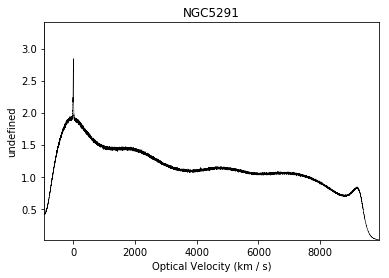

In [11]:
sp.xarr.convert_to_unit('km/s')
sp.plotter()
sp.plotter.label(verbose_label=True)   

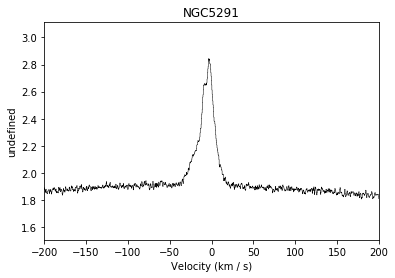

In [12]:
if src == '3C286':
    sp.plotter(xmin=207408,xmax=207598)
elif src == 'NGC5291':
    sp.plotter(xmin=-200, xmax=200)
elif src == 'NGC2347':
    print(src)
elif src == 'IC1481':
    print(src)

In [13]:
target.reduce("ps",verbose=True)
print(target)

REDUCE: beams= [1]
['A13', 'A9']
Nod Pair A13 (feed 1) has tsys1=19.841090 tsys2=19.515345
Nod Pair A9 (feed 1) has tsys1=20.028388 tsys2=19.667986
Object NGC5291 with 8 scan blocks and 2 'reduced' spectra
A13
A9


{'npts': 4573, 'std': 0.022053965878821403, 'mean': 0.27083827258109755, 'median': 0.27048905294933845, 'min': 0.18294566992065173, 'max': 0.35109388639600747}
{'npts': 4573, 'std': 0.022501133904958764, 'mean': 0.3232654535036684, 'median': 0.32354660892324544, 'min': 0.24858948665716019, 'max': 0.40233764622205487}


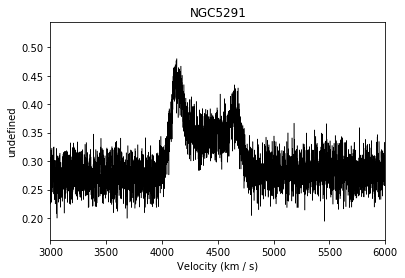

In [14]:
spol = target.reduced_scans
sp1 = spol['A13']   # YY
sp2 = spol['A9']    # XX
sp1.xarr.convert_to_unit('km/s')
sp2.xarr.convert_to_unit('km/s')
sp1.plotter()
sp1.plotter(xmin=3000,xmax=6000)
print(sp1.stats(statrange=(2000,3500)))
print(sp2.stats(statrange=(2000,3500)))

{'npts': 4573, 'std': 0.015865227200462524, 'mean': 0.297051863042383, 'median': 0.2966849625014419, 'min': 0.24276550127843746, 'max': 0.35313035830954154}


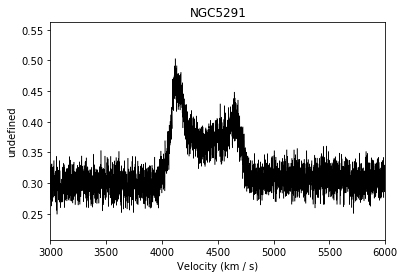

In [15]:
sp0 = sp2 
sp0.data = (sp1.data + sp2.data)/2.0
sp0.xarr.convert_to_unit('km/s')
sp0.plotter()
sp0.plotter(xmin=3000,xmax=6000)
print(sp0.stats(statrange=(2000,3500)))


GBTIDL:

     all         0.29499     0.015594   0.24217    0.35120     
     plnum=0     0.26889     0.021646   0.18349     0.35730
     plnum=1     0.32124     0.022386   0.24074     0.40275
   